## Task 1: Improving Fraud

2 checks:

• Document check: To verify that the photo ID is valid and authentic;

• Facial Similarity check: To verify that the face in the picture is the same as that on the
submitted ID.

The customer will ‘pass’ the KYC process and get onboarded if the results of both Document
and Facial Similarity checks are ‘clear’. If the result of any check is not ‘clear’, the customer has
to submit all the photos again.

Passing Rate = #customers who pass 2 stages of process/#customers who attempt the process

#### Problem: Passing Rate has been going up recently. WHY?


### Explore & Clean Data

In [1]:
#import the necessary libraries 
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
import plotly.figure_factory as ff
import plotly.express as px
import statsmodels.api as sm
from scipy import stats
from scipy.stats import ttest_1samp, ttest_rel, ttest_ind

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Document Reports 


According to the documentation:


- visual_authenticity - Asserts whether visual, non-textual, elements are correct given the type of document
- image_integrity - Asserts whether the document was of sufficient quality to verify
- image_quality
- supported_document
- conclusive_document_quality 
- colour picture_result
- data_validation - Asserts whether algorithmically-validatable elements are correct e.g. MRZ lines and document numbers
- data_consistency - Asserts whether data represented in multiple places on the document is consistent e.g. between MRZ lines and OCR extracted text on passports
- data_comparison - Asserts whether data on the document is consistent with data provided by an applicant (either through Veritas’s applicant form or when creating an applicant through the API)
- police_record - Asserts whether the document has been identified as lost, stolen or otherwise compromised
- compromised_document - Asserts whether the image of the document has been found in our internal database of compromised documents
- properties: The properties associated with the report, if any.

In [62]:
doc_reports = pd.read_csv('doc_reports.csv')

In [63]:
#change column name to avoid confusion with facial simulation data
doc_reports.rename(columns={"visual_authenticity_result": "visual_authenticity_doc", 
                            "image_integrity_result": "image_integrity_doc",
                            "result":"result_doc"}, inplace = True)
doc_reports.head()

,Unnamed: 0,user_id,result_doc,visual_authenticity_doc,image_integrity_doc,face_detection_result,image_quality_result,created_at,supported_document_result,conclusive_document_quality_result,colour_picture_result,data_validation_result,data_consistency_result,data_comparison_result,attempt_id,police_record_result,compromised_document_result,properties,sub_result
0,0,ab23fae164e34af0a1ad1423ce9fd9f0,consider,consider,clear,clear,clear,2017-06-20T23:12:57Z,clear,NaN,NaN,clear,clear,NaN,050a0596de424fab83c433eaa18b3f8d,clear,NaN,"{'gender': 'Male', 'nationality': 'IRL', 'docu...",caution
1,1,15a84e8951254011b47412fa4e8f65b8,clear,clear,clear,clear,clear,2017-06-20T23:16:04Z,clear,NaN,NaN,clear,NaN,NaN,f69c1e5f45a64e50a26740b9bfb978b7,clear,NaN,"{'gender': 'Female', 'document_type': 'driving...",clear
2,2,ffb82fda52b041e4b9af9cb4ef298c85,clear,clear,clear,clear,clear,2017-06-20T17:59:49Z,clear,NaN,NaN,clear,clear,NaN,f9f84f3055714d8e8f7419dc984d1769,clear,NaN,"{'gender': 'Male', 'nationality': 'ITA', 'docu...",clear
3,3,bd4a8b3e3601427e88aa1d9eab9f4290,clear,clear,clear,clear,clear,2017-06-20T17:59:38Z,clear,NaN,NaN,clear,clear,NaN,10a54a1ecf794404be959e030f11fef6,clear,NaN,"{'gender': 'Male', 'issuing_date': '2007-08', ...",clear
4,4,f52ad1c7e69543a9940c3e7f8ed28a39,clear,clear,clear,clear,clear,2017-06-20T18:08:09Z,clear,NaN,NaN,clear,clear,NaN,1f320d1d07de493292b7e0d5ebfb1cb9,clear,NaN,"{'gender': 'Male', 'nationality': 'POL', 'docu...",clear


In [283]:
doc_reports.columns

Index(['user_id', 'result_doc', 'visual_authenticity_doc',
       'image_integrity_doc', 'face_detection_result', 'image_quality_result',
       'supported_document_result', 'conclusive_document_quality_result',
       'colour_picture_result', 'data_validation_result',
       'data_consistency_result', 'data_comparison_result', 'attempt_id',
       'police_record_result', 'compromised_document_result', 'properties',
       'sub_result'],
      dtype='object')

In [64]:
doc_reports['sub_result'].unique()

array(['caution', 'clear', 'suspected', 'rejected'], dtype=object)

##### Data Cleaning

What is sub-result? Seems like providing the same info as result
if sub_result had consider instead of caution

When sub_result is clear --> result is also clear 
However, we have other attributes for sub_result that might indicate something for the problem in question. 

Also index number is > number of rows indicating some attemps might not be included in the dataset 


In [65]:
doc_reports.drop(['Unnamed: 0', 'created_at'], inplace = True, axis =1)

In [66]:
doc_reports.shape

(176404, 17)

In [67]:
#Number of (unique) users 
users = len(doc_reports['user_id'].unique())
print("Number of unique users:", users)
attempts = len(doc_reports['attempt_id'].unique())

print("Overall Pass Ratio:", round(users/attempts,3)*100, "%")

Number of unique users: 142724
Overall Pass Ratio: 80.9 %


##### GOAL: Analyse how the different stages impact the 'result'column

### Facial Similarity Reports 

The facial similarity check will compare the most recent live photo or live video provided by the applicant to the photo in the most recent identity document provided.

- face_comparison - Asserts whether the face in the document matches the face in the live photo or live video
- image_integrity - Asserts whether the quality of the uploaded files and the content contained within them were sufficient to perform a face comparison
- visual_authenticity - Asserts whether the live photo or live video is not a spoof (such as photos of printed photos or photos of digital screens)

In [68]:
facial_similarity_reports = pd.read_csv('facial_similarity_reports.csv')

In [70]:
facial_similarity_reports.columns

Index(['Unnamed: 0', 'user_id', 'result', 'face_comparison_result',
       'created_at', 'facial_image_integrity_result',
       'visual_authenticity_result', 'properties', 'attempt_id'],
      dtype='object')

In [71]:
#drop columns without information
facial_similarity_reports.drop(['properties', 'Unnamed: 0'], axis=1, inplace = True)

facial_similarity_reports.rename(columns={"result":"result_facial"}, inplace = True)

In [72]:
facial_similarity_reports.shape

#awesome both have the same number of data entries 

(176404, 7)

In [73]:
#Number of (unique) users 
users_facial = len(facial_similarity_reports['user_id'].unique())
print("Number of unique users:", users_facial)

attempts = len(facial_similarity_reports['attempt_id'].unique())

print("Overall Pass Ratio:", round(users_facial/attempts,3)*100, "%")

#Result is the same --> makes sense to merge both dataframes so that we can analyse better

Number of unique users: 142724
Overall Pass Ratio: 80.9 %


#### Merge two dfs

Assumptions:
- merge with attempt_id
- we only need 1 user_id, date, 

In [459]:
doc_face = pd.merge(doc_reports, facial_similarity_reports, on='attempt_id')
doc_face.head()

,user_id_x,result_doc,visual_authenticity_doc,image_integrity_doc,face_detection_result,image_quality_result,supported_document_result,conclusive_document_quality_result,colour_picture_result,data_validation_result,...,police_record_result,compromised_document_result,properties,sub_result,user_id_y,result_facial,face_comparison_result,created_at,facial_image_integrity_result,visual_authenticity_result
0,ab23fae164e34af0a1ad1423ce9fd9f0,consider,consider,clear,clear,clear,clear,NaN,NaN,clear,...,clear,NaN,"{'gender': 'Male', 'nationality': 'IRL', 'docu...",caution,ab23fae164e34af0a1ad1423ce9fd9f0,clear,clear,2017-06-20T23:12:58Z,clear,consider
1,15a84e8951254011b47412fa4e8f65b8,clear,clear,clear,clear,clear,clear,NaN,NaN,clear,...,clear,NaN,"{'gender': 'Female', 'document_type': 'driving...",clear,15a84e8951254011b47412fa4e8f65b8,clear,clear,2017-06-20T23:16:04Z,clear,clear
2,ffb82fda52b041e4b9af9cb4ef298c85,clear,clear,clear,clear,clear,clear,NaN,NaN,clear,...,clear,NaN,"{'gender': 'Male', 'nationality': 'ITA', 'docu...",clear,ffb82fda52b041e4b9af9cb4ef298c85,clear,clear,2017-06-20T17:59:49Z,clear,clear
3,bd4a8b3e3601427e88aa1d9eab9f4290,clear,clear,clear,clear,clear,clear,NaN,NaN,clear,...,clear,NaN,"{'gender': 'Male', 'issuing_date': '2007-08', ...",clear,bd4a8b3e3601427e88aa1d9eab9f4290,clear,clear,2017-06-20T17:59:39Z,clear,clear
4,f52ad1c7e69543a9940c3e7f8ed28a39,clear,clear,clear,clear,clear,clear,NaN,NaN,clear,...,clear,NaN,"{'gender': 'Male', 'nationality': 'POL', 'docu...",clear,f52ad1c7e69543a9940c3e7f8ed28a39,clear,clear,2017-06-20T18:08:09Z,clear,clear


In [460]:
doc_face.columns

Index(['user_id_x', 'result_doc', 'visual_authenticity_doc',
       'image_integrity_doc', 'face_detection_result', 'image_quality_result',
       'supported_document_result', 'conclusive_document_quality_result',
       'colour_picture_result', 'data_validation_result',
       'data_consistency_result', 'data_comparison_result', 'attempt_id',
       'police_record_result', 'compromised_document_result', 'properties',
       'sub_result', 'user_id_y', 'result_facial', 'face_comparison_result',
       'created_at', 'facial_image_integrity_result',
       'visual_authenticity_result'],
      dtype='object')

In [461]:
#Null values
null_cols = doc_face.isnull().sum()
null_cols[null_cols > 0].sort_values(ascending=False)

data_comparison_result                173855
compromised_document_result           130897
data_consistency_result                84175
conclusive_document_quality_result     81186
colour_picture_result                  81181
data_validation_result                 33430
police_record_result                   31847
face_detection_result                  26143
visual_authenticity_doc                26114
visual_authenticity_result             26114
face_comparison_result                 10397
supported_document_result                504
facial_image_integrity_result            463
image_integrity_doc                        1
image_quality_result                       1
result_facial                              1
dtype: int64

In [462]:
doc_face['created_at'] = pd.to_datetime(doc_face['created_at'])

In [463]:
(doc_face['result_facial'] ==doc_face['face_comparison_result']).unique()


array([ True, False])

In [464]:
#make sure correct
print((doc_face['user_id_x'] ==doc_face['user_id_y']).unique())

#remove face_comparison since we already have facial_result
doc_face.drop(['user_id_y','face_comparison_result'], inplace = True, axis=1)
doc_face.rename(columns={"user_id_x":"user_id", "created_at_x":"created_at"}, inplace = True)

[ True]


##### ADD FINAL RESULT COLUMN 

The customer will ‘pass’ the KYC process and get onboarded if the results of both Document
and Facial Similarity checks are ‘clear’. If the result of any check is not ‘clear’, the customer has
to submit all the photos again.

In [465]:
doc_face['final_result'] = np.where((doc_face['result_facial']=='clear')& (doc_face['result_doc']=='clear'), 
                                    'pass', 'fail')

In [466]:
doc_face.head()

,user_id,result_doc,visual_authenticity_doc,image_integrity_doc,face_detection_result,image_quality_result,supported_document_result,conclusive_document_quality_result,colour_picture_result,data_validation_result,...,attempt_id,police_record_result,compromised_document_result,properties,sub_result,result_facial,created_at,facial_image_integrity_result,visual_authenticity_result,final_result
0,ab23fae164e34af0a1ad1423ce9fd9f0,consider,consider,clear,clear,clear,clear,NaN,NaN,clear,...,050a0596de424fab83c433eaa18b3f8d,clear,NaN,"{'gender': 'Male', 'nationality': 'IRL', 'docu...",caution,clear,2017-06-20 23:12:58+00:00,clear,consider,fail
1,15a84e8951254011b47412fa4e8f65b8,clear,clear,clear,clear,clear,clear,NaN,NaN,clear,...,f69c1e5f45a64e50a26740b9bfb978b7,clear,NaN,"{'gender': 'Female', 'document_type': 'driving...",clear,clear,2017-06-20 23:16:04+00:00,clear,clear,pass
2,ffb82fda52b041e4b9af9cb4ef298c85,clear,clear,clear,clear,clear,clear,NaN,NaN,clear,...,f9f84f3055714d8e8f7419dc984d1769,clear,NaN,"{'gender': 'Male', 'nationality': 'ITA', 'docu...",clear,clear,2017-06-20 17:59:49+00:00,clear,clear,pass
3,bd4a8b3e3601427e88aa1d9eab9f4290,clear,clear,clear,clear,clear,clear,NaN,NaN,clear,...,10a54a1ecf794404be959e030f11fef6,clear,NaN,"{'gender': 'Male', 'issuing_date': '2007-08', ...",clear,clear,2017-06-20 17:59:39+00:00,clear,clear,pass
4,f52ad1c7e69543a9940c3e7f8ed28a39,clear,clear,clear,clear,clear,clear,NaN,NaN,clear,...,1f320d1d07de493292b7e0d5ebfb1cb9,clear,NaN,"{'gender': 'Male', 'nationality': 'POL', 'docu...",clear,clear,2017-06-20 18:08:09+00:00,clear,clear,pass


In [467]:
df = doc_face.groupby('final_result')['user_id'].nunique()
df[1]/(df[0]+df[1])

0.7818680469715699

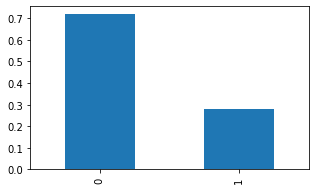

In [487]:
doc_face.final_result.value_counts(normalize=True).plot.bar(figsize=(5, 3))

In [469]:
mapping = {"clear": 0, 'unidentified': 1, "consider" : 1, "pass" : 0, "fail" : 1}

def encode_function(columns, df):
    for column in columns:
        df[column] = df[column].map(mapping)
    
columns = doc_face.drop(['user_id', 'attempt_id', 'properties', 'created_at'], axis=1)
encode_function(columns,doc_face)

In [470]:
doc_face.dtypes

user_id                                            object
result_doc                                          int64
visual_authenticity_doc                           float64
image_integrity_doc                               float64
face_detection_result                             float64
image_quality_result                              float64
supported_document_result                         float64
conclusive_document_quality_result                float64
colour_picture_result                             float64
data_validation_result                            float64
data_consistency_result                           float64
data_comparison_result                            float64
attempt_id                                         object
police_record_result                              float64
compromised_document_result                       float64
properties                                         object
sub_result                                        float64
result_facial 

### Data Analysis

In [471]:
attempts_count = doc_face.groupby([pd.Grouper(key='created_at', freq='D')])['user_id'].count()
fail_count = doc_face[doc_face['final_result'] ==1].groupby([pd.Grouper(key='created_at', freq='D')])['user_id'].count()

result = pd.concat([attempts_count, fail_count], axis=1)
result.columns = ['Number of Attempts', 'Number of Fails']
result['Pass Rate'] =(result['Number of Attempts']-result['Number of Fails'])/result['Number of Attempts']
result


,Number of Attempts,Number of Fails,Pass Rate
created_at,,,
2017-05-23 00:00:00+00:00,100,22,0.780000
2017-05-24 00:00:00+00:00,194,40,0.793814
2017-05-25 00:00:00+00:00,165,27,0.836364
2017-05-26 00:00:00+00:00,213,37,0.826291
2017-05-27 00:00:00+00:00,174,32,0.816092
...,...,...,...
2017-10-27 00:00:00+00:00,2003,825,0.588118
2017-10-28 00:00:00+00:00,1489,447,0.699799
2017-10-29 00:00:00+00:00,1393,365,0.737976


In [472]:
result.dtypes

Number of Attempts      int64
Number of Fails         int64
Pass Rate             float64
dtype: object

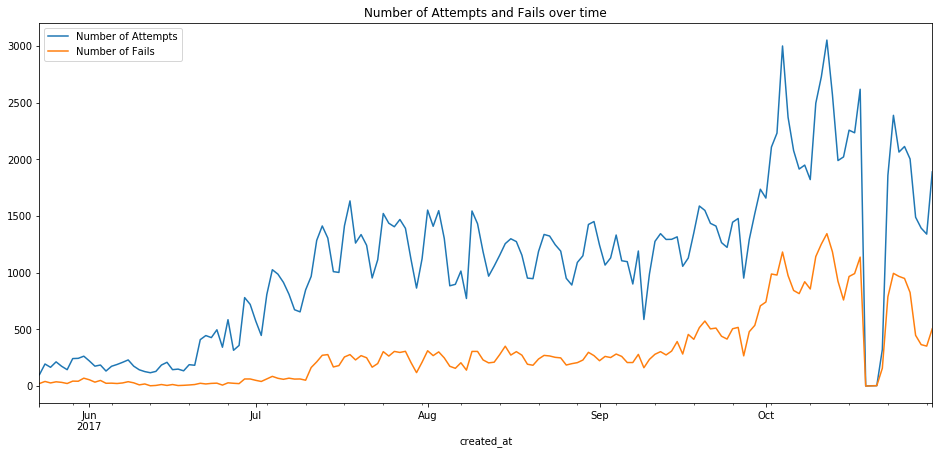

In [473]:
#plot
result[['Number of Attempts', 'Number of Fails']].plot(figsize=(16, 7), title='Number of Attempts and Fails over time')




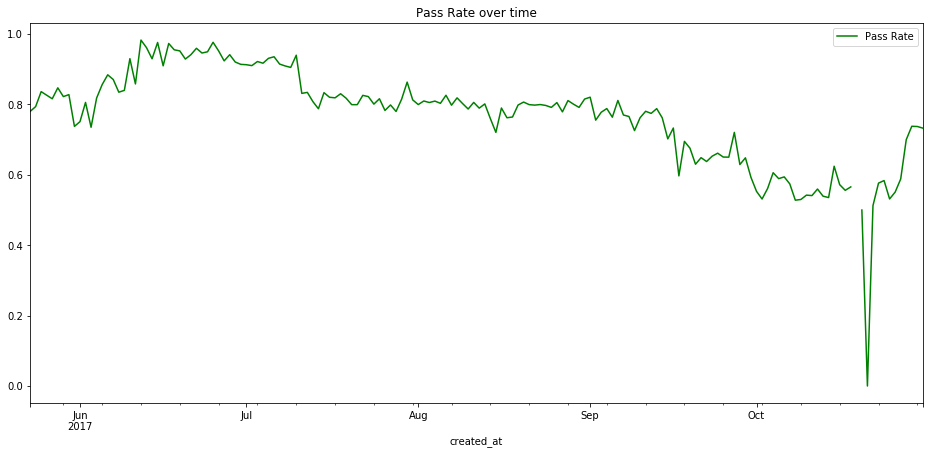

In [474]:
result[['Pass Rate']].plot(figsize=(16, 7), color='g', title='Pass Rate over time')

#### The 3 graphs together:

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


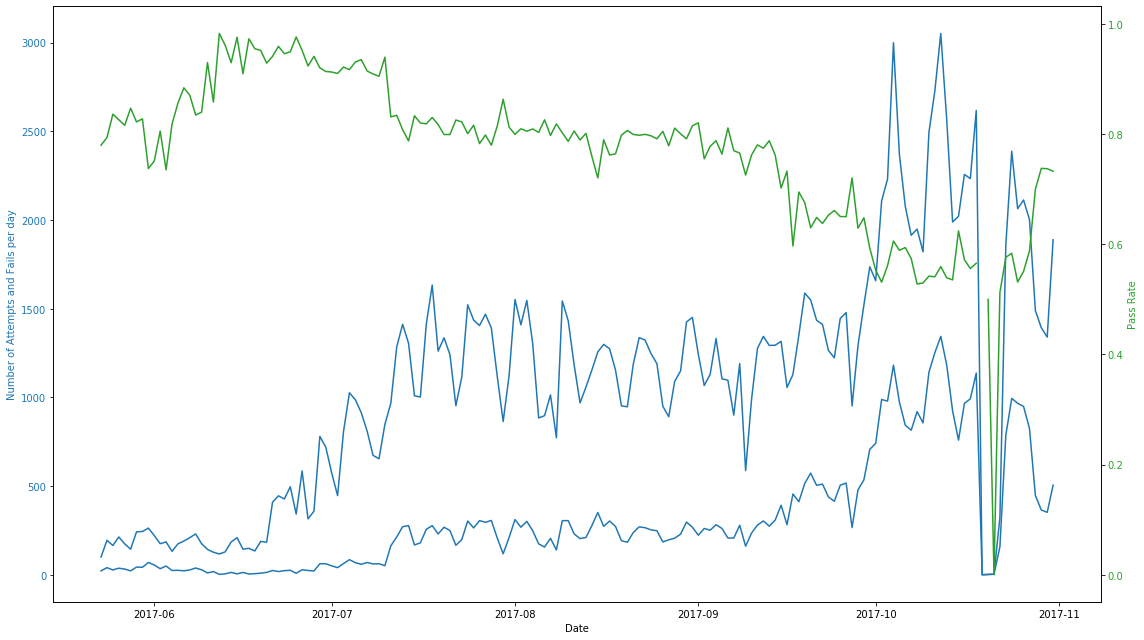

In [475]:
fig, ax1 = plt.subplots()

data1 = result[['Number of Attempts', 'Number of Fails']]
data2 = result[['Pass Rate']]

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Attempts and Fails per day', color=color)
ax1.plot(result.index, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:green'
ax2.set_ylabel('Pass Rate', color=color)  
ax2.plot(result.index, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()# otherwise the right y-label is slightly clipped
plt.show()

In [482]:
graph_columns = columns.drop(['sub_result','final_result'], axis=1).columns

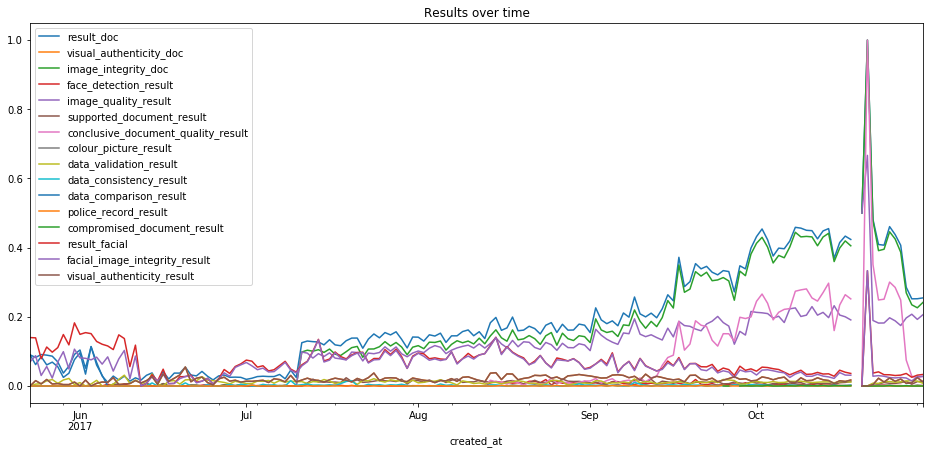

In [483]:
doc_face.groupby(pd.Grouper(key='created_at', freq='D'))[graph_columns].mean().plot(figsize=(16, 7), 
                                                                                 title='Results over time')


#### Graph:
    
- Number of 'not clear' attempts have more or less followed the distribution of the number of submissions.
- We see a significant submissions decrease during October.
- Looking at the data for that specific month we have 3 days in particular with aprox null attemps (so it's normal that the pass rate has decreased substantially in the recent period...)

### Correlation

In [484]:
# Finding the relations between the variables
corr =doc_face.drop(['sub_result'], axis=1).corr()

#look at the results
corr[['result_doc','result_facial']].sort_values(by=['result_doc','result_facial'], 
                                                 ascending=[False, False])

,result_doc,result_facial
result_doc,1.000000,0.145877
image_integrity_doc,0.935447,0.119411
final_result,0.922866,0.411173
conclusive_document_quality_result,0.899578,-0.002755
data_comparison_result,0.897684,0.001509
image_quality_result,0.695039,0.154876
visual_authenticity_result,0.390227,0.161617
visual_authenticity_doc,0.390227,0.161617
data_validation_result,0.283832,0.014762
supported_document_result,0.171676,0.054647


- image_integrity_doc is the variable with highest correlation with the document result check. According to the API Documentation, asserts whether the document is of sufficient quality to verify (in the case to perform the facial comparison)
- facial_image_integrity_result: Asserts whether the quality of the uploaded files and the content contained within them were sufficient to perform a face comparison


These parameters have a great influence on the final KYC result.

In [358]:
#Look at October --> 3 days with missing/wrong information
result[result.index> '2017-10-18']

,Number of attempts,Number of Fails,Pass Rate
created_at,,,
2017-10-19 00:00:00+00:00,0,0,NaN
2017-10-20 00:00:00+00:00,2,1,0.500000
2017-10-21 00:00:00+00:00,3,3,0.000000
2017-10-22 00:00:00+00:00,322,157,0.512422
2017-10-23 00:00:00+00:00,1858,787,0.576426
2017-10-24 00:00:00+00:00,2388,994,0.583752
2017-10-25 00:00:00+00:00,2064,967,0.531492
2017-10-26 00:00:00+00:00,2113,949,0.550876
2017-10-27 00:00:00+00:00,2003,825,0.588118


In [188]:
doc_face_october = doc_face[doc_face['created_at']>'2017-10-01']

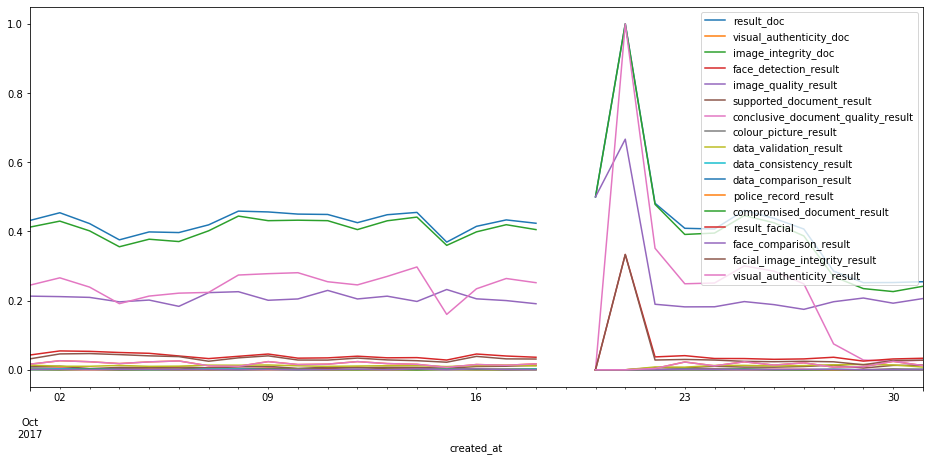

In [361]:
doc_face_october.groupby(pd.Grouper(key='created_at', freq='D'))[corr.index].mean().plot(figsize=(16, 7))

#we can see that some parameters had bigger impact during that period in mid-October 

In [360]:
# Finding the relations between the variables
corr =doc_face_october.drop(['sub_result','final_result'], axis=1).corr()

#look at the results
corr[['result_doc','result_facial']].sort_values(by=['result_doc','result_facial'], 
                                                 ascending=[False, False])

,result_doc,result_facial
result_doc,1.000000,0.117895
image_integrity_doc,0.963673,0.096621
conclusive_document_quality_result,0.937947,0.001141
image_quality_result,0.606713,0.135799
visual_authenticity_doc,0.229702,0.196022
visual_authenticity_result,0.229702,0.196022
data_validation_result,0.184734,0.015179
result_facial,0.117895,1.000000
facial_image_integrity_result,0.114149,0.989670
supported_document_result,0.109130,0.067607


##### troubling fields during those days:

- No data from 18-20 included 
- on the 21th the failure rate for "image_integrity_result" and "concludive_document_result" increased to 1, while "image_quality_Result" and "facial_image_integrity_result"also showed a abnormal failure increase for the day. 

### Look into Properties


In [401]:
#check attempts with no properties information
print("Number of total attempts:", doc_face.shape[0])
print("Number of total failed attempts:", doc_face[doc_face['final_result'] == 1].shape[0])

print("Number of attempts without properties data:", 
      doc_face[doc_face['properties'] == "{}"].shape[0])

print("Number of attempts with failed image_integrity_doc:", 
      doc_face[doc_face['image_integrity_doc'] == 1].shape[0])

print("Number of attempts with failed image_quality_result :", 
      doc_face[doc_face['image_quality_result'] == 1].shape[0])

print("Number of attempts without properties data and failed image_integrity_doc & image_quality_result:", 
      doc_face[(doc_face['properties'] == "{}")&(doc_face['image_quality_result'] == 1)& 
               (doc_face['image_integrity_doc'] == 1)].shape[0])

Number of total attempts: 176403
Number of total failed attempts: 49514
Number of attempts without properties data: 26098
Number of attempts with failed image_integrity_doc: 39743
Number of attempts with failed image_quality_result : 24403
Number of attempts without properties data and failed image_integrity_doc & image_quality_result: 24390


In [402]:
24390/26098

0.9345543719825274

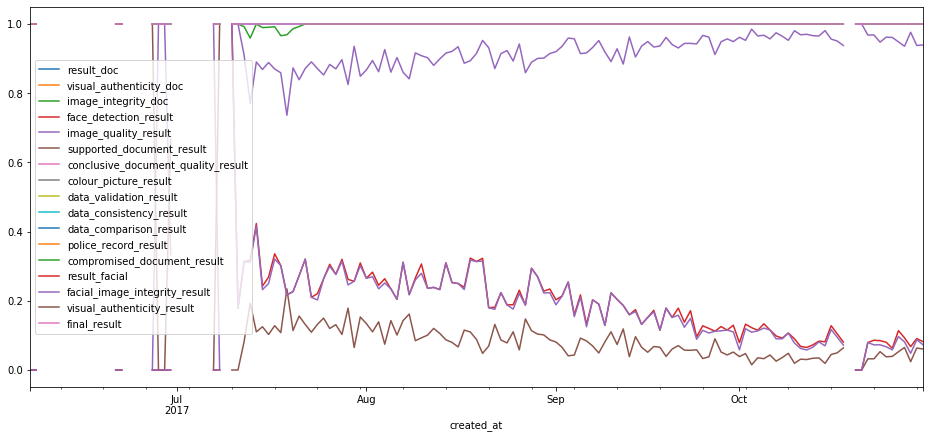

In [393]:
doc_face[doc_face['properties'] == "{}"].groupby(pd.Grouper(key='created_at', freq='D'))[corr.index].mean().plot(figsize=(16, 7))

In [396]:
#what are the average check results for tests with no properties data?

doc_face[doc_face['properties'] == "{}"].mean().dropna()

#On average, 99.9% no properties submissions fail the image integrity document check.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


result_doc                       1.000000
image_integrity_doc              0.999157
image_quality_result             0.934554
supported_document_result        0.065867
result_facial                    0.157445
facial_image_integrity_result    0.150601
final_result                     1.000000
dtype: float64

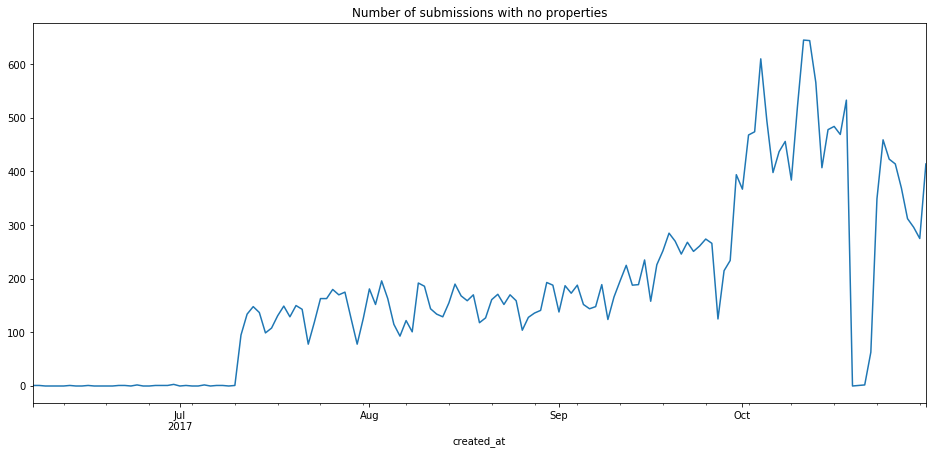

In [410]:
no_properties = doc_face[doc_face['properties'] == "{}"].groupby([pd.Grouper(key='created_at', freq='D')])['user_id'].count()
no_properties.plot(figsize=(16, 7), title='Number of submissions with no properties')

#### Unpack Dictionary 

In [174]:
#clean and unwrap informations
doc_face['properties'] = doc_face['properties'].apply(lambda x: x.strip("\'<>()").replace('\'', '\"'))
doc_face['properties']  = doc_face['properties'] .apply(lambda row: row.replace('None', "\"NaN\""))

In [175]:
doc_face['properties'] = doc_face['properties'].apply(lambda x : dict(eval(x)) )
df3 = doc_face['properties'].apply(pd.Series )

In [177]:
#merge with big df
final = doc_face.merge(df3,left_index=True, right_index=True)

In [362]:
#function that plots any detail, top 10 (some details have too many)
def plot_count(df, detail):
    fail = df[df['final_result'] == 1].groupby(detail).count()['final_result'].sort_values(ascending =False).head(10)
    submissions = df.groupby(detail).count()['final_result'].sort_values(ascending =False).head(10)
    graph = pd.concat([fail, submissions], axis=1)
    graph.columns = ['Failed Submissions','All Submissions' ]
    return graph.plot(kind='bar', title=detail)

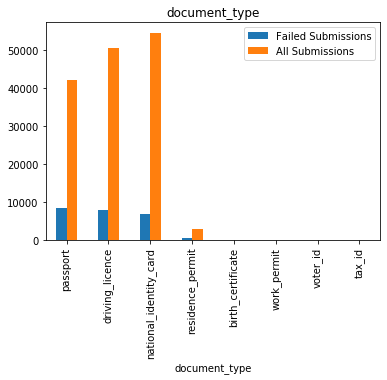

In [363]:
plot_count(final, 'document_type')

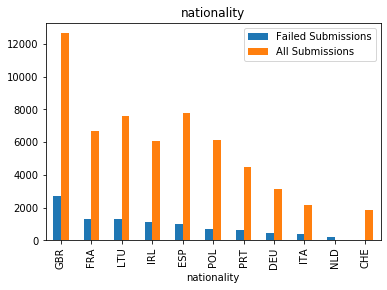

In [364]:
plot_count(final, 'nationality')

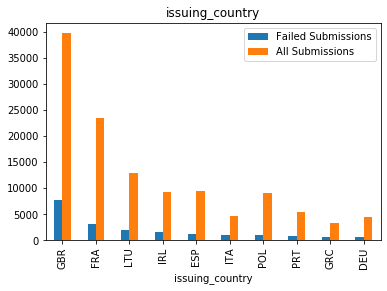

In [365]:
plot_count(final, 'issuing_country')

### Looking at the spefic days where we saw the drop: 

In [366]:
detail = final[(final['created_at']>'2017-10-15')&
               (final['created_at']<'2017-10-25')].sort_values(by='created_at', ascending =False)

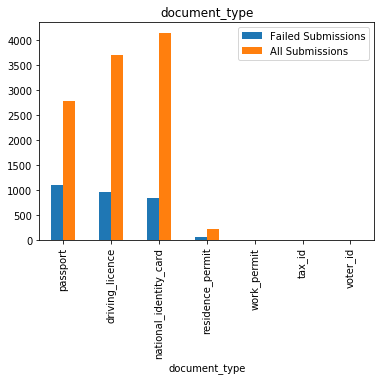

In [367]:
plot_count(detail,'document_type')

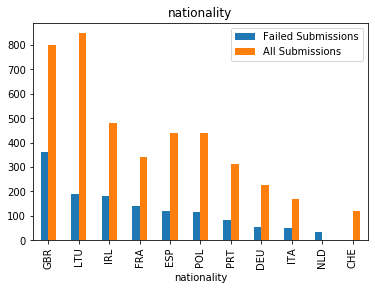

In [368]:
plot_count(detail, 'nationality')

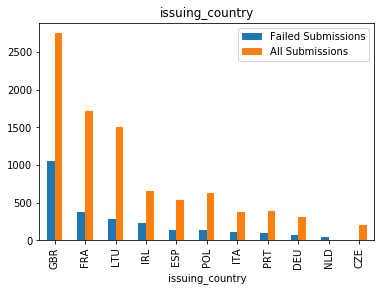

In [369]:
plot_count(detail,'issuing_country')

In [497]:
corr =detail.drop('sub_result', axis=1).corr()

#look at the results
corr = corr[['result_doc','result_facial']].sort_values(by='result_doc', ascending =False)
corr

,result_doc,result_facial
result_doc,1.000000,0.120733
final_result,0.978334,0.229878
image_integrity_doc,0.970759,0.103561
conclusive_document_quality_result,0.950092,0.012388
image_quality_result,0.593581,0.138853
visual_authenticity_doc,0.202962,0.213047
visual_authenticity_result,0.202962,0.213047
data_validation_result,0.177028,-0.008442
result_facial,0.120733,1.000000
supported_document_result,0.114511,0.075406


In [498]:
corr.style.background_gradient(cmap='coolwarm')

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,result_doc,result_facial
result_doc,1.000000,0.120733
final_result,0.978334,0.229878
image_integrity_doc,0.970759,0.103561
conclusive_document_quality_result,0.950092,0.012388
image_quality_result,0.593581,0.138853
visual_authenticity_doc,0.202962,0.213047
visual_authenticity_result,0.202962,0.213047
data_validation_result,0.177028,-0.008442
result_facial,0.120733,1.000000
supported_document_result,0.114511,0.075406


## Conclusions and Recommendations:

'Know Your Customer’ (KYC) or 'Customer Due Diligence' (CDD), is a mandatory and extremely important process that allows for identity verification and further protection against corruption and fraud. The process, conducted by Veritas, identifies potential discrepancies between the information shared and identification document submitted through multiple checks (e.g. data integrity, visual authenticity and police record checks). In addition, any data extracted from the document through OCR is returned in the properties attribute.

Throughout the analysis, we could verify a problematic period of time with anomalous low registration numbers and results (18th-22nd October), possibly a result of a Veritas technical software and/or data processing infrastructure problem, if not with the app itself. Furthermore, the results indicate an overall contraction of the KYC pass test rate during the time interval evaluated, possibly indicating a more structural issue.

As an early adopter and daily user with related verification mechanisms, problems like these are often driven by technical issues. More specifically, incompatibility between the app/software and smartphone operating system and the versions being used.
- Given the behaviour of the pass rate curve, it could make sense for users to be progressively installing a new App Version with verification issues. This problematic scenario could also explain the sudden drop in the number of registrations: the day the old app version would become unavailable.

According to the API documentation, the document report combines software and an expert team to maximise fraud detection: "The majority of documents will be processed instantly. However, when document analysis falls back to the expert review, the report status will be delivered asynchronously via webhook notifications." Asynchronously report delivery is absolute key information, meaning that the data is transmitted intermittently rather than in a steady stream.
- The results of this analysis show an increase in suspicious image integrity and quality checks, possibly leading to a higher necessity for expert review instead of automatic checks. It could be the case that Veritas provided customer information with a lag or simply due to the lack of experts to perform the manual review.

I would recommend the company to incentivise consumers in using national ID, instead of passport, as it seems to be the most reliable document. A higher level of collaboration and understanding of the veritas software and its interaction with the App (e.g. create a team or task force within Fin Crime with this particular focus), as well as a more extensive audit at Veritas processes and data reporting. Finally, the company should investigate the possibility of investing in its own internal software verification product and expert review team management, from a more long-term perspective. 